## **Import and EDA**

In [8]:
%pip install -U accelerate 
%pip install -U peft 
%pip install -U trl 
%pip install -U bitsandbytes 

Note: you may need to restart the kernel to use updated packages.


In [9]:
from datasets import Dataset, DatasetDict,concatenate_datasets 
from transformers import AutoModelForSequenceClassification, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel, PeftConfig
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

2024-07-25 09:03:22.330047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 09:03:22.330155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 09:03:22.473673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
df = pd.read_csv('/kaggle/input/lmsys-chatbot-arena/train.csv')
df.head(2)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0


In [11]:
def process(input_str):
    stripped_str = input_str.strip('[]')
    sentences = [s.strip('"') for s in stripped_str.split('","')]
    return  ' '.join(sentences)

In [12]:
df['input'] = 'USER PROMPT: '+df.prompt.apply(process)+'\n MODEL_A RESPONSE: '+df.response_a.apply(process)+'\n MODEL_B RESPONSE: '+df.response_b.apply(process)
# Find the index of the maximum value across the columns for each row
df['labels'] = [[float(a),float(b),float(t)] for a,b,t in zip(df['winner_model_a'], df['winner_model_b'], df['winner_tie'])]

# Drop the columns if no longer needed
df.drop(columns=['id','model_a','model_b','prompt','response_a','response_b','winner_model_a', 'winner_model_b', 'winner_tie'], inplace=True)
df.head(2)


,input,labels
0,USER PROMPT: Is it morally right to try to hav...,"[1.0, 0.0, 0.0]"
1,USER PROMPT: What is the difference between ma...,"[0.0, 1.0, 0.0]"


In [13]:
print('max input length: ',max([len(input_text) for input_text in df.input]))
print('min input length: ',min([len(input_text) for input_text in df.input]))

max input length:  76389
min input length:  66


<Axes: ylabel='Count'>

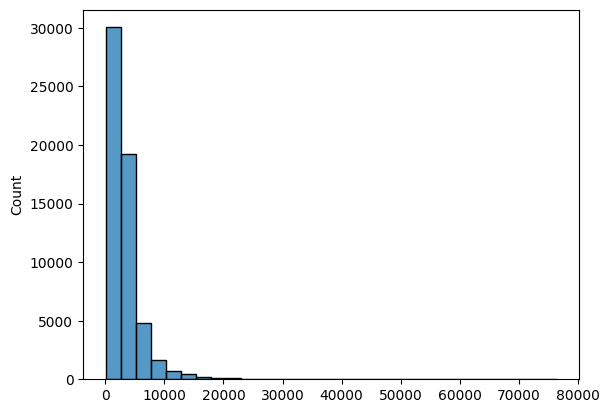

In [14]:
sns.histplot([len(prompt) for prompt in df.input],bins=30)

## **Tokenization** 

In [15]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['input', 'labels'],
    num_rows: 57477
})

In [16]:
model_name='microsoft/deberta-v3-large'

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [18]:
def tok_func(x):
    x['input_ids'] = tokenizer(x["input"],  max_length=512,padding="max_length", truncation=True, return_tensors="pt").input_ids
    return x

In [19]:
ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

## **Validation set**

In [35]:
dds = ds.train_test_split(0.05, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['input', 'labels', 'input_ids'],
        num_rows: 54603
    })
    test: Dataset({
        features: ['input', 'labels', 'input_ids'],
        num_rows: 2874
    })
})

## **Fine tuning**

In [21]:
from sklearn.metrics import log_loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    return {
        'eval_log_loss': log_loss(labels, probabilities),
        'eval_accuracy': (np.argmax(logits, axis=1) == labels).mean()
    }

def logloss(eval_pred):
    predictions, labels = eval_pred
    return {"log_loss": log_loss(labels,predictions)}

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=3)

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 435064835
all model parameters: 435064835
percentage of trainable model parameters: 100.00%


## **PEFT Lora**

In [24]:
lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    target_modules=['query_proj', 'value_proj','key_proj']
)

In [25]:
peft_model = get_peft_model(model,lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 4724742
all model parameters: 439786502
percentage of trainable model parameters: 1.07%


In [26]:
lr = 5e-5  

peft_training_args = TrainingArguments(
   'outputs', learning_rate=lr, warmup_ratio=0.1, 
    lr_scheduler_type='linear',fp16=True, 
    auto_find_batch_size=True,
#     evaluation_strategy="epoch",
    logging_steps=1, max_steps=5,  
    metric_for_best_model = "eval_log_loss",
    greater_is_better = False,
    weight_decay=0.01, report_to='none'
)


peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=dds['train'],
    eval_dataset=dds['test'],
    tokenizer=tokenizer, 
    compute_metrics=compute_metrics
)

max_steps is given, it will override any value given in num_train_epochs


In [27]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [28]:
peft_trainer.train()

Step,Training Loss
1,1.075900
2,1.096500
3,1.112300
4,1.127400
5,1.068500


TrainOutput(global_step=5, training_loss=1.0961243391036988, metrics={'train_runtime': 9.5202, 'train_samples_per_second': 4.202, 'train_steps_per_second': 0.525, 'total_flos': 37857830584320.0, 'train_loss': 1.0961243391036988, 'epoch': 0.000732493407559332})

## **Model Evaluation**

In [29]:
actual = np.array(dds['test']['labels'])
test_ds = dds['test'].remove_columns('labels')

In [30]:
test_ds

Dataset({
    features: ['input', 'input_ids'],
    num_rows: 2874
})

In [31]:
probs = peft_trainer.predict(test_ds).predictions.astype(float)
# Initialize an array of zeros with the same shape as probs
preds = np.zeros_like(probs)

# Use np.argmax to find the index of the max value in each row
max_indices = np.argmax(probs, axis=1)
preds[np.arange(preds.shape[0]), max_indices] = 1

In [37]:
actual.shape,preds.shape

((2874, 3), (2874, 3))

In [39]:
print(logloss((actual,preds)))

{'log_loss': 23.815900412642122}


In [40]:
from sklearn.metrics import classification_report

In [41]:
print(classification_report(actual, preds))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51       975
           1       0.00      0.00      0.00      1021
           2       0.00      0.00      0.00       878

   micro avg       0.34      0.34      0.34      2874
   macro avg       0.11      0.33      0.17      2874
weighted avg       0.12      0.34      0.17      2874
 samples avg       0.34      0.34      0.34      2874



In [42]:
preds

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])